In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plot style
sns.set_style('whitegrid')

In [3]:
TRAIN_PATH = '../Dataset/train.csv'
TEST_PATH = '../Dataset/test.csv'

In [3]:
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print("Data loaded successfully!")
    print("\nTraining data shape:", train_df.shape)
    print("Testing data shape:", test_df.shape)
except FileNotFoundError:
    print("Ensure train.csv and test.csv are in the correct directory.")

# Display the first few rows of the training data
print("\nFirst 5 rows of training data:")
display(train_df.head())

Data loaded successfully!

Training data shape: (1200, 81)
Testing data shape: (260, 80)

First 5 rows of training data:


,Id,PropertyClass,ZoningCategory,RoadAccessLength,LandArea,RoadType,ServiceLaneType,PlotShape,LandElevation,UtilityAccess,...,SwimmingPoolArea,PoolQuality,BoundaryFence,ExtraFacility,ExtraFacilityValue,MonthSold,YearSold,DealType,DealCondition,HotelValue
0,775,20,RL,110.0,14226,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,New,Partial,395000.0
1,673,20,RL,NaN,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,165000.0
2,234,20,RL,75.0,10650,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,128200.0
3,427,80,RL,NaN,12800,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,275000.0
4,197,20,RL,79.0,9416,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2007,New,Partial,311872.0


# Data Pre-processing

In [4]:
# Store test IDs for the final submission files
test_ids = test_df['Id']

# Drop the 'Id' column
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

# Separate the target variable
y = train_df['HotelValue']
train_features = train_df.drop('HotelValue', axis=1)

# Combine for consistent preprocessing
all_features = pd.concat([train_features, test_df], axis=0).reset_index(drop=True)

# Handle missing values
numerical_cols = all_features.select_dtypes(include=np.number).columns.tolist()
categorical_cols = all_features.select_dtypes(exclude=np.number).columns.tolist()
for col in numerical_cols:
    all_features[col] = all_features[col].fillna(all_features[col].median())
for col in categorical_cols:
    all_features[col] = all_features[col].fillna(all_features[col].mode()[0])

# One-hot encode categorical features
all_features_encoded = pd.get_dummies(all_features, columns=categorical_cols, drop_first=True)

# Separate back into training and testing sets
X = all_features_encoded.iloc[:len(train_df)]
X_test = all_features_encoded.iloc[len(train_df):]

# Align columns
train_cols = X.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
X_test = X_test[train_cols]

# --- Create a validation set to evaluate models ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing complete.")
print("Training feature shape:", X_train.shape)
print("Validation feature shape:", X_val.shape)
print("Testing feature shape:", X_test.shape)

Preprocessing complete.
Training feature shape: (960, 244)
Validation feature shape: (240, 244)
Testing feature shape: (260, 244)


In [ ]:
def print_evaluation_metrics(y_true, y_pred, X_data):
    """Calculates and prints a comprehensive set of regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"Mean Squared Error (MSE):  ${mse:,.2f}")
    print(f"Root Mean Squared Error:   ${rmse:,.2f}")
    print(f"R-squared (R²):            {r2:.4f}")
    
    n = X_data.shape[0] # Number of samples
    p = X_data.shape[1] # Number of features
    if n > p + 1:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print(f"Adjusted R-squared:        {adj_r2:.4f}")
    else:
        print("Adjusted R-squared:        Not calculated (more features than samples)")

# Models

## Linear Regression

In [9]:
print("--- Model 1: Linear Regression ---")

# 1. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 2. Train the model on the training set
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 3. Evaluate the model on the validation set
print("Validation Metrics:")
val_preds = lr_model.predict(X_val_scaled)
print_evaluation_metrics(y_val, val_preds, X_val)

# 4. Retrain on the FULL dataset for final prediction
X_scaled_full = scaler.fit_transform(X) # Re-fit scaler on all data
X_test_scaled_full = scaler.transform(X_test)
lr_model.fit(X_scaled_full, y)

# 5. Predict on test data and save
test_predictions = lr_model.predict(X_test_scaled_full)
submission_df = pd.DataFrame({'Id': test_ids, 'HotelValue': test_predictions})
submission_df.to_csv('linear.csv', index=False)
print("\nPredictions saved to 'linear.csv'")

--- Model 1: Linear Regression ---
Validation Metrics:
Mean Absolute Error (MAE): $22,272.77
Mean Squared Error (MSE):  $4,139,099,285.45
Root Mean Squared Error:   $64,335.83
R-squared (R²):            0.4091
Adjusted R-squared:        29.2442

Predictions saved to 'linear.csv'


## Ridge Regression

--- Model 2: Ridge Regression ---


c:\Users\Darsh Veer Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal Alpha (Lambda): 666.9920

Validation Metrics:
Mean Absolute Error (MAE): $20,005.07
Mean Squared Error (MSE):  $1,003,832,932.50
Root Mean Squared Error:   $31,683.32
R-squared (R²):            0.8567
Adjusted R-squared:        7.8499


c:\Users\Darsh Veer Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


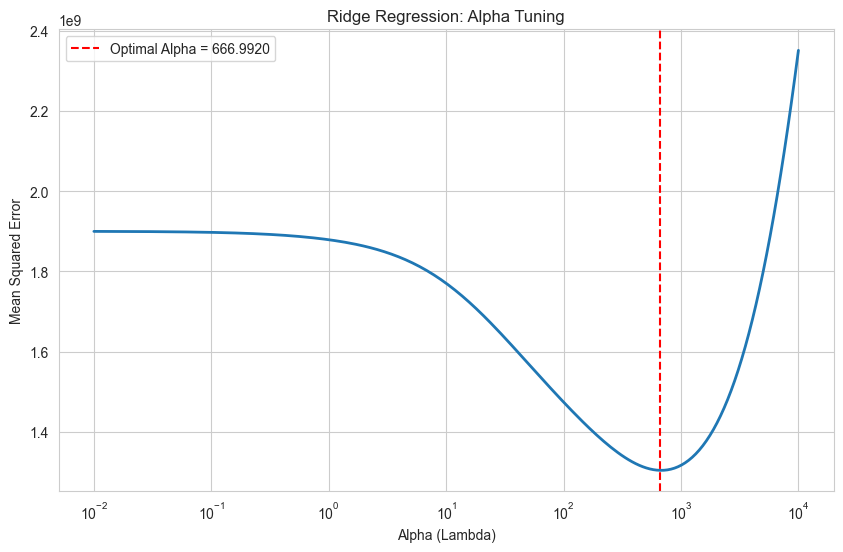


Predictions saved to 'ridge.csv'


In [10]:
print("--- Model 2: Ridge Regression ---")

# 1. Scale the data
scaler_ridge = StandardScaler()
X_train_scaled_ridge = scaler_ridge.fit_transform(X_train)
X_val_scaled_ridge = scaler_ridge.transform(X_val)

# 2. Tune hyperparameters on the training set
alphas = np.logspace(-2, 4, 200)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled_ridge, y_train)
best_alpha = ridge_cv.alpha_
print(f"Optimal Alpha (Lambda): {best_alpha:.4f}\n")

# 3. Evaluate the best model on the validation set
print("Validation Metrics:")
val_preds_ridge = ridge_cv.predict(X_val_scaled_ridge)
print_evaluation_metrics(y_val, val_preds_ridge, X_val)

# --- Plotting the Hyperparameter Tuning ---
mse_path = np.mean(ridge_cv.cv_values_, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(ridge_cv.alphas, mse_path, linewidth=2)
plt.axvline(best_alpha, linestyle='--', color='r', label=f'Optimal Alpha = {best_alpha:.4f}')
plt.xscale('log')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression: Alpha Tuning')
plt.legend()
plt.grid(True)
plt.show()

# 4. Retrain on the FULL dataset with the best alpha
X_scaled_full_ridge = scaler_ridge.fit_transform(X)
X_test_scaled_full_ridge = scaler_ridge.transform(X_test)
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_scaled_full_ridge, y)

# 5. Predict and save
test_predictions_ridge = final_ridge.predict(X_test_scaled_full_ridge)
submission_df_ridge = pd.DataFrame({'Id': test_ids, 'HotelValue': test_predictions_ridge})
submission_df_ridge.to_csv('ridge.csv', index=False)
print("\nPredictions saved to 'ridge.csv'")

## LASSO Regression

--- Model 3: LASSO Regression ---
Optimal Alpha (Lambda): 3274.5492

Validation Metrics:
Mean Absolute Error (MAE): $23,971.49
Mean Squared Error (MSE):  $1,285,170,397.09
Root Mean Squared Error:   $35,849.27
R-squared (R²):            0.8165
Adjusted R-squared:        9.7697
Optimal Alpha (Lambda): 3274.5492

Validation Metrics:
Mean Absolute Error (MAE): $23,971.49
Mean Squared Error (MSE):  $1,285,170,397.09
Root Mean Squared Error:   $35,849.27
R-squared (R²):            0.8165
Adjusted R-squared:        9.7697


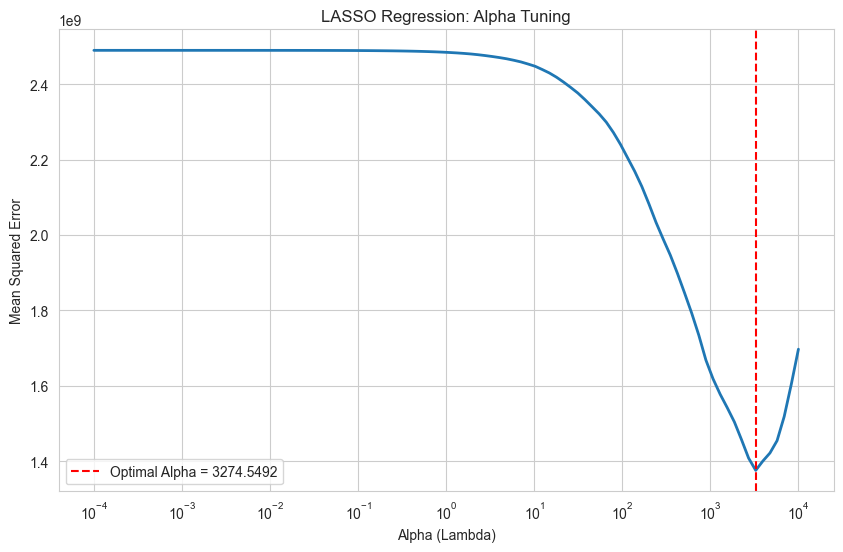


Predictions saved to 'lasso.csv'


In [17]:
# Run LASSO block only once per kernel to avoid duplicate outputs when re-running cells
if 'lasso_run' in globals():
    print('LASSO already executed in this kernel session. To re-run, `del lasso_run` and re-run this cell.')
else:
    lasso_run = True
    print("--- Model 3: LASSO Regression ---")

    # 1. Scale the data
    scaler_lasso = StandardScaler()
    X_train_scaled_lasso = scaler_lasso.fit_transform(X_train)
    X_val_scaled_lasso = scaler_lasso.transform(X_val)

    # 2. Tune hyperparameters on the training set
    lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, max_iter=10000, random_state=42)
    lasso_cv.fit(X_train_scaled_lasso, y_train)
    best_alpha_lasso = lasso_cv.alpha_
    print(f"Optimal Alpha (Lambda): {best_alpha_lasso:.4f}\n")

    # 3. Evaluate on the validation set
    print("Validation Metrics:")
    val_preds_lasso = lasso_cv.predict(X_val_scaled_lasso)
    print_evaluation_metrics(y_val, val_preds_lasso, X_val)

    # --- Plotting the Hyperparameter Tuning ---
    mse_path_lasso = np.mean(lasso_cv.mse_path_, axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(lasso_cv.alphas_, mse_path_lasso, linewidth=2)
    plt.axvline(best_alpha_lasso, linestyle='--', color='r', label=f'Optimal Alpha = {best_alpha_lasso:.4f}')
    plt.xscale('log')
    plt.xlabel('Alpha (Lambda)')
    plt.ylabel('Mean Squared Error')
    plt.title('LASSO Regression: Alpha Tuning')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Retrain on FULL dataset with best alpha
    X_scaled_full_lasso = scaler_lasso.fit_transform(X)
    X_test_scaled_full_lasso = scaler_lasso.transform(X_test)
    final_lasso = Lasso(alpha=best_alpha_lasso, max_iter=10000)
    final_lasso.fit(X_scaled_full_lasso, y)

    # 5. Predict and save
    test_predictions_lasso = final_lasso.predict(X_test_scaled_full_lasso)
    submission_df_lasso = pd.DataFrame({'Id': test_ids, 'HotelValue': test_predictions_lasso})
    submission_df_lasso.to_csv('lasso.csv', index=False)
    print("\nPredictions saved to 'lasso.csv'")

## Elastic Net

--- Model 4: Elastic Net Regression ---
Optimal Alpha (Lambda): 75.6463
Optimal L1 Ratio: 0.99

Optimal Alpha (Lambda): 75.6463
Optimal L1 Ratio: 0.99



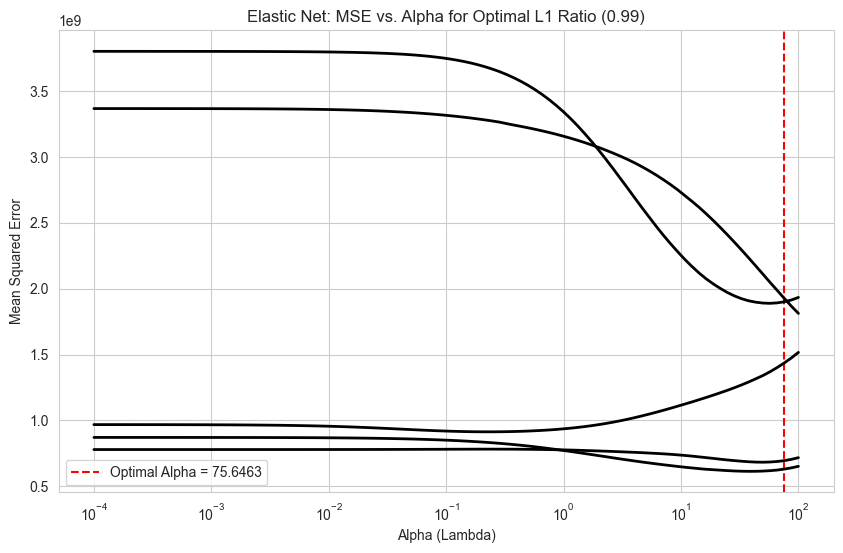

Validation Metrics:
Mean Absolute Error (MAE): $20,170.33
Mean Squared Error (MSE):  $1,018,948,777.02
Root Mean Squared Error:   $31,920.98
R-squared (R²):            0.8545
Adjusted R-squared:        Not calculated (more features than samples)

Predictions saved to 'elastic.csv'


In [ ]:
import warnings
warnings.filterwarnings('ignore') # Suppress convergence warnings for clarity

print("--- Model 4: Elastic Net Regression ---")

# 1. Scale the data
scaler_elastic = StandardScaler()
X_train_scaled_elastic = scaler_elastic.fit_transform(X_train)
X_val_scaled_elastic = scaler_elastic.transform(X_val)

# 2. Define the parameters to test
l1_ratios_to_test = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
alphas_to_test = np.logspace(-4, 2, 100)

# 3. Tune hyperparameters using ElasticNetCV
elastic_net_cv = ElasticNetCV(
    l1_ratio=l1_ratios_to_test,
    alphas=alphas_to_test,
    cv=5,
    max_iter=10000,
    random_state=42
)
elastic_net_cv.fit(X_train_scaled_elastic, y_train)

best_alpha_elastic = elastic_net_cv.alpha_
best_l1_ratio = elastic_net_cv.l1_ratio_
print(f"Optimal Alpha (Lambda): {best_alpha_elastic:.4f}")
print(f"Optimal L1 Ratio: {best_l1_ratio}\n")

# --- Plotting the Hyperparameter Tuning ---
# Find the index of the best l1_ratio
best_l1_ratio_index = l1_ratios_to_test.index(best_l1_ratio)

mse_path_for_best_ratio = elastic_net_cv.mse_path_[best_l1_ratio_index, :]

plt.figure(figsize=(10, 6))
# The 'alphas_' attribute corresponds to the alphas used for the best path
plt.plot(elastic_net_cv.alphas_, mse_path_for_best_ratio, 'k', linewidth=2, zorder=5)
plt.axvline(best_alpha_elastic, linestyle='--', color='r', label=f'Optimal Alpha = {best_alpha_elastic:.4f}')
plt.xscale('log')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error')
plt.title(f'Elastic Net: MSE vs. Alpha for Optimal L1 Ratio ({best_l1_ratio})')
plt.legend()
plt.grid(True)
plt.show()

# 4. Evaluate on the validation set (using the corrected metrics function)
print("Validation Metrics:")
val_preds_elastic = elastic_net_cv.predict(X_val_scaled_elastic)
print_evaluation_metrics(y_val, val_preds_elastic, X_val)

# 5. Retrain on FULL dataset with best parameters
X_scaled_full_elastic = scaler_elastic.fit_transform(X)
X_test_scaled_full_elastic = scaler_elastic.transform(X_test)
final_elastic = ElasticNet(alpha=best_alpha_elastic, l1_ratio=best_l1_ratio, max_iter=10000)
final_elastic.fit(X_scaled_full_elastic, y)

# 6. Predict and save
test_predictions_elastic = final_elastic.predict(X_test_scaled_full_elastic)
submission_df_elastic = pd.DataFrame({'Id': test_ids, 'HotelValue': test_predictions_elastic})
submission_df_elastic.to_csv('elastic.csv', index=False)
print("\nPredictions saved to 'elastic.csv'")

# Ridge Regression (Full Dataset)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

print("--- Training Ridge Regression on 100% of Data ---")

# 1. Load Data
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'train.csv' and 'test.csv' must be in the same directory.")

# 2. Preprocessing (on 100% of train data)
test_ids = test_df['Id']

# Drop 'Id'
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

# Separate the full training dataset
y = train_df['HotelValue']
X = train_df.drop('HotelValue', axis=1)

# Combine X (full training set) and test_df for consistent preprocessing
all_features = pd.concat([X, test_df], axis=0).reset_index(drop=True)

# Handle missing values
numerical_cols = all_features.select_dtypes(include=np.number).columns.tolist()
categorical_cols = all_features.select_dtypes(exclude=np.number).columns.tolist()
for col in numerical_cols:
    all_features[col] = all_features[col].fillna(all_features[col].median())
for col in categorical_cols:
    all_features[col] = all_features[col].fillna(all_features[col].mode()[0])

# One-hot encode categorical features
all_features_encoded = pd.get_dummies(all_features, columns=categorical_cols, drop_first=True)

# Separate back into the full training set (X_full) and test set (X_test)
X_full = all_features_encoded.iloc[:len(train_df)]
X_test = all_features_encoded.iloc[len(train_df):]

# Align columns to ensure test set has the same features as the training set
train_cols = X_full.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
X_test = X_test[train_cols]

print("Preprocessing complete.")

# 3. Scale Data
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test)

# 4. Train and Tune with RidgeCV
# Define a range of alphas to test
alphas = np.logspace(-2, 4, 200)

# CORRECTED: Removed 'store_cv_values=True' to fix the error
ridge_cv_final = RidgeCV(alphas=alphas, cv=5)
ridge_cv_final.fit(X_scaled_full, y)

best_alpha = ridge_cv_final.alpha_
print(f"\nOptimal Alpha (Lambda) found using 100% data: {best_alpha:.4f}")

# 5. Infer on test.csv
# The 'ridge_cv_final' object is now the fully trained model.
test_predictions = ridge_cv_final.predict(X_test_scaled)

# 6. Save Output
submission_df_ridge = pd.DataFrame({'Id': test_ids, 'HotelValue': test_predictions})
submission_df_ridge.to_csv('ridge.csv', index=False)

print("\nPredictions saved to 'ridge.csv'")
display(submission_df_ridge.head())

--- Training Ridge Regression on 100% of Data ---
Data loaded successfully.
Preprocessing complete.

Optimal Alpha (Lambda) found using 100% data: 505.2631

Predictions saved to 'ridge.csv'

Optimal Alpha (Lambda) found using 100% data: 505.2631

Predictions saved to 'ridge.csv'


,Id,HotelValue
0,893,150650.390170
1,1106,315229.043359
2,414,94914.660594
3,523,171489.770961
4,1037,309362.063357


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
import warnings

# Suppress warnings, as Elastic Net often has convergence warnings
warnings.filterwarnings('ignore')

print("--- Training Elastic Net on 100% of Data ---")

# 1. Load Data
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'train.csv' and 'test.csv' must be in the same directory.")

# 2. Preprocessing (on 100% of train data)
test_ids = test_df['Id']

# Drop 'Id'
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

# Separate the full training dataset
y = train_df['HotelValue']
X = train_df.drop('HotelValue', axis=1)

# Combine X (full training set) and test_df for consistent preprocessing
all_features = pd.concat([X, test_df], axis=0).reset_index(drop=True)

# Handle missing values
numerical_cols = all_features.select_dtypes(include=np.number).columns.tolist()
categorical_cols = all_features.select_dtypes(exclude=np.number).columns.tolist()
for col in numerical_cols:
    all_features[col] = all_features[col].fillna(all_features[col].median())
for col in categorical_cols:
    all_features[col] = all_features[col].fillna(all_features[col].mode()[0])

# One-hot encode categorical features
all_features_encoded = pd.get_dummies(all_features, columns=categorical_cols, drop_first=True)

# Separate back into the full training set (X_full) and test set (X_test)
X_full = all_features_encoded.iloc[:len(train_df)]
X_test = all_features_encoded.iloc[len(train_df):]

# Align columns to ensure test set has the same features as the training set
train_cols = X_full.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
X_test = X_test[train_cols]

print("Preprocessing complete.")

# 3. Scale Data
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test)

# 4. Train and Tune with ElasticNetCV
# Define hyperparameter ranges to test
alphas = np.logspace(-4, 2, 100) # Range from 0.0001 to 100
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0] # Test a wide mix

elastic_cv_final = ElasticNetCV(
    alphas=alphas,
    l1_ratio=l1_ratios,
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores to speed up the search
)
elastic_cv_final.fit(X_scaled_full, y)

best_alpha = elastic_cv_final.alpha_
best_l1_ratio = elastic_cv_final.l1_ratio_
print(f"\nOptimal Alpha (Lambda) found: {best_alpha:.4f}")
print(f"Optimal L1 Ratio found: {best_l1_ratio}")

# 5. Infer on test.csv
test_predictions = elastic_cv_final.predict(X_test_scaled)

# 6. Save Output
submission_df_elastic = pd.DataFrame({'Id': test_ids, 'HotelValue': test_predictions})
submission_df_elastic.to_csv('elastic.csv', index=False)

print("\nPredictions saved to 'elastic.csv'")
display(submission_df_elastic.head())

--- Training Elastic Net on 100% of Data ---
Data loaded successfully.
Preprocessing complete.

Optimal Alpha (Lambda) found: 49.7702
Optimal L1 Ratio found: 0.99

Predictions saved to 'elastic.csv'

Optimal Alpha (Lambda) found: 49.7702
Optimal L1 Ratio found: 0.99

Predictions saved to 'elastic.csv'


,Id,HotelValue
0,893,150272.735722
1,1106,312934.084470
2,414,95809.102724
3,523,169589.891713
4,1037,307328.207159


# Boosting Models

## All

In [10]:
# --- 1. Import Necessary Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import the three boosting models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb  # This requires the 'xgboost' library to be installed

# --- 2. Your Evaluation Function ---
def print_evaluation_metrics(y_true, y_pred, X_data, model_name="Model"):
    """Calculates and prints a comprehensive set of regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    # Using $ format as in your function
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}") 
    print(f"Mean Squared Error (MSE):  ${mse:,.2f}")
    print(f"Root Mean Squared Error:   ${rmse:,.2f}")
    print(f"R-squared (R²):            {r2:.4f}")
    
    n = X_data.shape[0] # Number of samples
    p = X_data.shape[1] # Number of features
    if n > p + 1:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print(f"Adjusted R-squared:        {adj_r2:.4f}")
    else:
        # This case can happen after one-hot encoding if there are many categories
        print(f"Adjusted R-squared:        Not calculated (n={n}, p={p})")
    print("-" * 40)

# --- 3. Load Data ---
# This assumes 'train.csv' is in the same directory as your script/notebook
try:
    df_train = pd.read_csv(TRAIN_PATH)
    print("Successfully loaded train.csv")
    print(f"Shape of training data: {df_train.shape}\n")
except FileNotFoundError:
    print("Error: train.csv not found.")
    exit()

# --- 4. Preprocessing ---
print("Starting preprocessing...")

# Define Target (y) and Features (X)
y = df_train['HotelValue']
X = df_train.drop(['Id', 'HotelValue'], axis=1)

# Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

print(f"Found {len(numeric_features)} numeric features and {len(categorical_features)} categorical features.")

# Handle Missing Values
# For numeric features, fill with the median
for col in numeric_features:
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)
    
# For categorical features, fill with the mode (most frequent value)
for col in categorical_features:
    mode_val = X[col].mode()[0]
    X[col] = X[col].fillna(mode_val)
    
print("Missing values imputed.")

# One-Hot Encoding for categorical features
X_processed = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Categorical features one-hot encoded. New feature count: {X_processed.shape[1]}")
print("Preprocessing complete.")
print("=" * 40)

# --- 5. Create the 80-20 Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, 
    y, 
    test_size=0.2, 
    random_state=42
)

print(f"Data split complete: {len(X_train)} training samples, {len(X_test)} testing samples.")
print("=" * 40)


# --- 6. AdaBoost (Adaptive Boosting) ---

print("Training AdaBoost Regressor...")
ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)
ada_preds = ada_model.predict(X_test)

# Evaluate using your function
print_evaluation_metrics(y_test, ada_preds, X_test, model_name="AdaBoost")


# --- 7. Gradient Boosting Regressor (Scikit-learn) ---

print("Training Gradient Boosting Regressor...")
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
gbr_preds = gbr_model.predict(X_test)

# Evaluate using your function
print_evaluation_metrics(y_test, gbr_preds, X_test, model_name="Gradient Boosting")


# --- 8. XGBoost (Extreme Gradient Boosting) ---

print("Training XGBoost Regressor...")
# objective='reg:squarederror' is the standard for regression tasks
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate using your function
print_evaluation_metrics(y_test, xgb_preds, X_test, model_name="XGBoost")

print("\nAll models trained and evaluated.")

Successfully loaded train.csv
Shape of training data: (1200, 81)

Starting preprocessing...
Found 36 numeric features and 43 categorical features.
Missing values imputed.
Categorical features one-hot encoded. New feature count: 242
Preprocessing complete.
Data split complete: 960 training samples, 240 testing samples.
Training AdaBoost Regressor...
--- AdaBoost Evaluation ---
Mean Absolute Error (MAE): $27,392.17
Mean Squared Error (MSE):  $1,495,082,722.78
Root Mean Squared Error:   $38,666.30
R-squared (R²):            0.7866
Adjusted R-squared:        Not calculated (n=240, p=242)
----------------------------------------
Training Gradient Boosting Regressor...
--- AdaBoost Evaluation ---
Mean Absolute Error (MAE): $27,392.17
Mean Squared Error (MSE):  $1,495,082,722.78
Root Mean Squared Error:   $38,666.30
R-squared (R²):            0.7866
Adjusted R-squared:        Not calculated (n=240, p=242)
----------------------------------------
Training Gradient Boosting Regressor...
--- Gra

## Gradient Boosting with Hyperparameter Tuning

### GridSearch

Starting GridSearchCV for Gradient Boosting...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score (MSE): 720899326.67

--- Best Model Validation Metrics ---
MAE: $17,624.57
MSE: $737,208,511.86
RMSE: $27,151.58
R²: 0.8948

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score (MSE): 720899326.67

--- Best Model Validation Metrics ---
MAE: $17,624.57
MSE: $737,208,511.86
RMSE: $27,151.58
R²: 0.8948


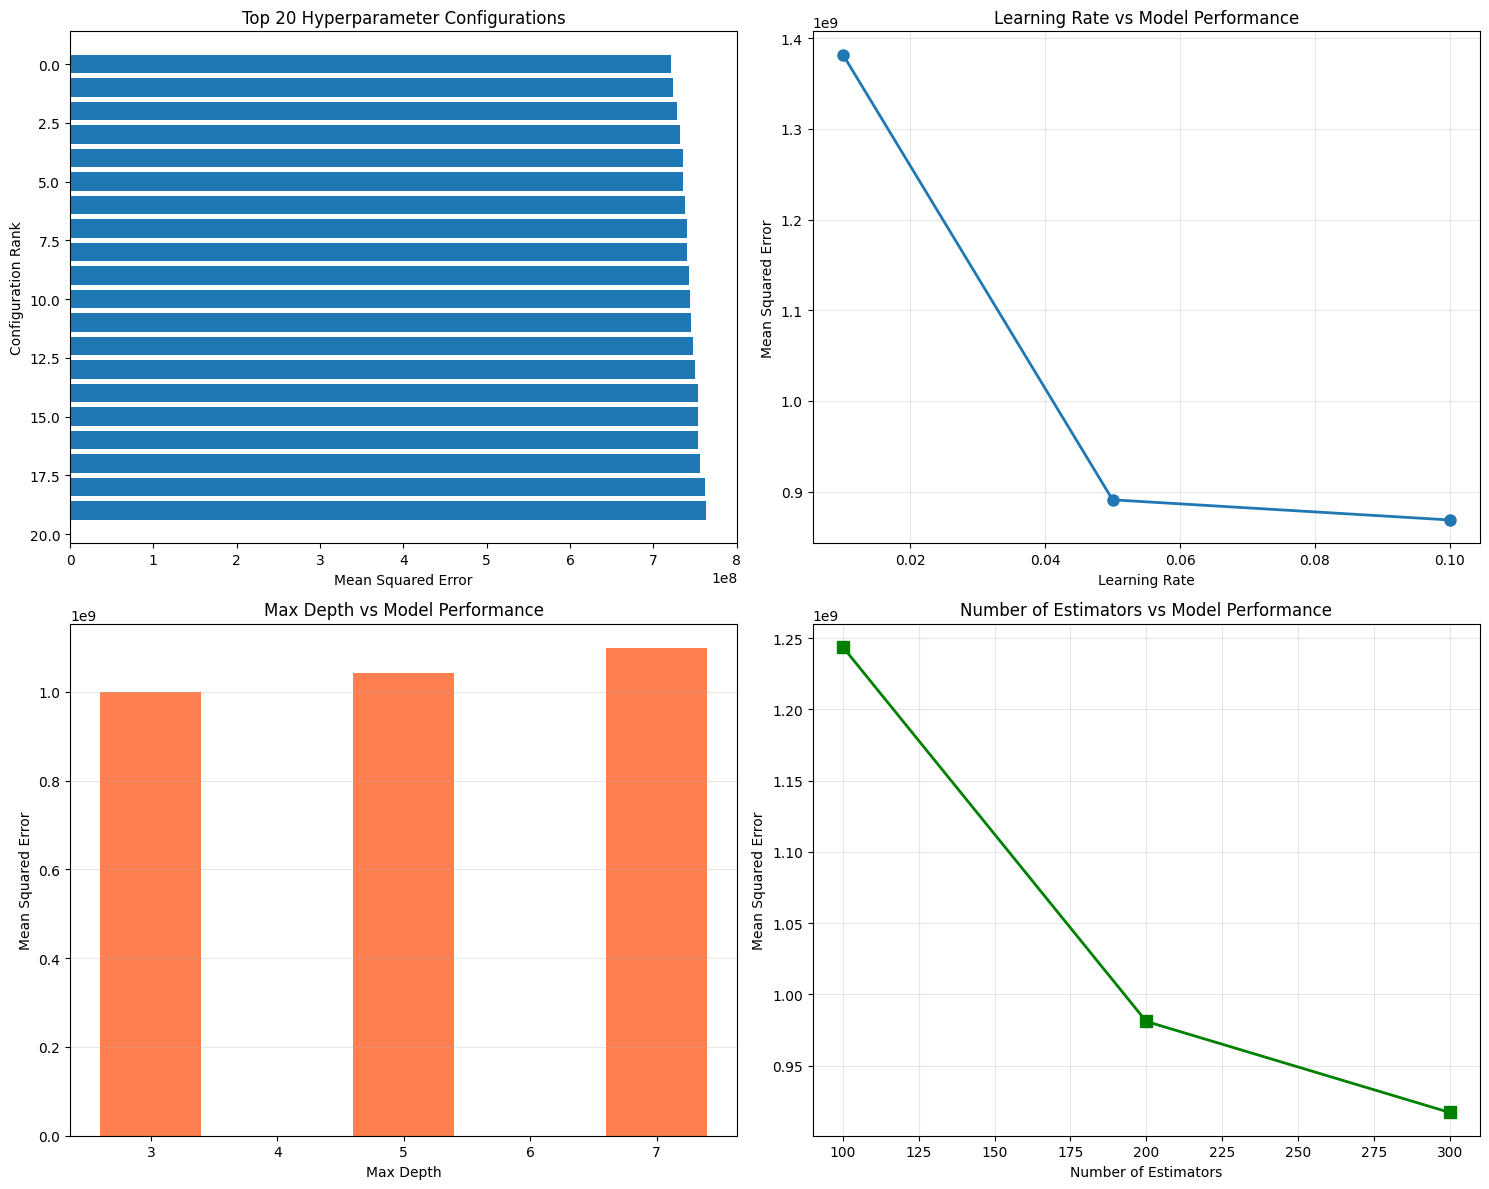


gradient_tuned.csv has been created!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load and Preprocess Data ---
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

y = train['HotelValue']
X = train.drop(['Id', 'HotelValue'], axis=1)

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# Handle missing values
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# One-hot encode
X_processed = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Create train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# --- Hyperparameter Grid ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

# --- GridSearchCV ---
print("Starting GridSearchCV for Gradient Boosting...")
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (MSE): {-grid_search.best_score_:.2f}")

# --- Train Best Model ---
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val)

# Evaluate
mae = mean_absolute_error(y_val, val_preds)
mse = mean_squared_error(y_val, val_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_preds)

print(f"\n--- Best Model Validation Metrics ---")
print(f"MAE: ${mae:,.2f}")
print(f"MSE: ${mse:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R²: {r2:.4f}")

# --- Visualization ---
results = pd.DataFrame(grid_search.cv_results_)

# Plot 1: Top 20 Hyperparameter Combinations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sort by mean test score
results_sorted = results.sort_values('mean_test_score', ascending=False).head(20)
axes[0, 0].barh(range(20), -results_sorted['mean_test_score'])
axes[0, 0].set_xlabel('Mean Squared Error')
axes[0, 0].set_ylabel('Configuration Rank')
axes[0, 0].set_title('Top 20 Hyperparameter Configurations')
axes[0, 0].invert_yaxis()

# Plot 2: Learning Rate vs Performance
lr_groups = results.groupby('param_learning_rate')['mean_test_score'].mean()
axes[0, 1].plot(lr_groups.index.astype(float), -lr_groups.values, marker='o', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].set_title('Learning Rate vs Model Performance')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Max Depth vs Performance
depth_groups = results.groupby('param_max_depth')['mean_test_score'].mean()
axes[1, 0].bar(depth_groups.index.astype(int), -depth_groups.values, color='coral')
axes[1, 0].set_xlabel('Max Depth')
axes[1, 0].set_ylabel('Mean Squared Error')
axes[1, 0].set_title('Max Depth vs Model Performance')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: N_estimators vs Performance
est_groups = results.groupby('param_n_estimators')['mean_test_score'].mean()
axes[1, 1].plot(est_groups.index.astype(int), -est_groups.values, marker='s', linewidth=2, markersize=8, color='green')
axes[1, 1].set_xlabel('Number of Estimators')
axes[1, 1].set_ylabel('Mean Squared Error')
axes[1, 1].set_title('Number of Estimators vs Model Performance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gradient_boosting_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Predict on Test Set ---
test_ids = test['Id']
X_test = test.drop(['Id'], axis=1)

for col in numeric_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna(X[col].median())
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna(X[col].mode()[0])

X_test_processed = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
X_test_processed = X_test_processed.reindex(columns=X_processed.columns, fill_value=0)

# Retrain on full training data
final_model = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
final_model.fit(X_processed, y)
test_preds = final_model.predict(X_test_processed)

# Save predictions
gradient_df = pd.DataFrame({'Id': test_ids, 'HotelValue': test_preds})
gradient_df.to_csv('gradient_tuned.csv', index=False)
print("\ngradient_tuned.csv has been created!")
